In [31]:
import boto3
import datetime
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import shutil
import tempfile

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [32]:
aws_psql_conn = psycopg2.connect(
    database=os.getenv("AWS_PSQL_DB"),
    user=os.getenv("AWS_PSQL_USER"),
    password=os.getenv("AWS_PSQL_PASSWORD"),
    host=os.getenv("AWS_PSQL_HOST"),
    port=os.getenv("AWS_PSQL_PORT"),
)

cursor = aws_psql_conn.cursor()

In [33]:
sql = f"select * from games"

cursor.execute(sql)

rows = cursor.fetchall()

column_names = [desc[0] for desc in cursor.description]

In [34]:
df = pd.DataFrame(rows, columns=column_names)

df.head()

,game_id,home_team_id,home_team_name,away_team_id,away_team_name,home_pitcher,home_pitcher_id,home_pitcher_era,home_pitcher_win_percentage,home_pitcher_wins,...,home_pitcher_bb_nine,home_pitcher_k_bb_diff,home_pitcher_whip,home_pitcher_babip,away_pitcher_k_nine,away_pitcher_bb_nine,away_pitcher_k_bb_diff,away_pitcher_whip,away_pitcher_babip,predicted_winner
0,718698,158,Milwaukee Brewers,121,New York Mets,Corbin Burnes,669203.0,7.2,0.0,0.0,...,5.4,0.0,1.4,0.25,9.0,1.8,0.181818,1.8,0.466667,1.0
1,718781,147,New York Yankees,137,San Francisco Giants,Gerrit Cole,543037.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,718782,111,Boston Red Sox,110,Baltimore Orioles,Corey Kluber,446372.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,718777,112,Chicago Cubs,158,Milwaukee Brewers,Marcus Stroman,573186.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,718776,139,Tampa Bay Rays,116,Detroit Tigers,Shane McClanahan,663556.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
columns_to_remove = [
    "home_team_name",
    "away_team_name",
    "home_pitcher",
    "home_pitcher_id",
    "away_pitcher",
    "away_pitcher_id",
]

df = df.drop(columns=columns_to_remove)

df.head()

,game_id,home_team_id,away_team_id,home_pitcher_era,home_pitcher_win_percentage,home_pitcher_wins,home_pitcher_losses,home_pitcher_innings_pitched,away_pitcher_era,away_pitcher_win_percentage,...,home_pitcher_bb_nine,home_pitcher_k_bb_diff,home_pitcher_whip,home_pitcher_babip,away_pitcher_k_nine,away_pitcher_bb_nine,away_pitcher_k_bb_diff,away_pitcher_whip,away_pitcher_babip,predicted_winner
0,718698,158,121,7.2,0.0,0.0,1.0,5.0,1.8,0.0,...,5.4,0.0,1.4,0.25,9.0,1.8,0.181818,1.8,0.466667,1.0
1,718781,147,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,718782,111,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,718777,112,158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,718776,139,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df = df.dropna()

df.head()

,game_id,home_team_id,away_team_id,home_pitcher_era,home_pitcher_win_percentage,home_pitcher_wins,home_pitcher_losses,home_pitcher_innings_pitched,away_pitcher_era,away_pitcher_win_percentage,...,home_pitcher_bb_nine,home_pitcher_k_bb_diff,home_pitcher_whip,home_pitcher_babip,away_pitcher_k_nine,away_pitcher_bb_nine,away_pitcher_k_bb_diff,away_pitcher_whip,away_pitcher_babip,predicted_winner
0,718698,158,121,7.20,0.000,0.0,1.0,5.0,1.8,0.0,...,5.40,0.000000,1.40,0.250000,9.0,1.80,0.181818,1.80,0.466667,1.0
72,718703,119,115,3.00,1.000,1.0,0.0,6.0,3.0,1.0,...,0.00,0.285714,0.67,0.285714,7.5,0.00,0.208333,0.83,0.294118,1.0
73,718704,120,139,6.00,0.000,0.0,1.0,3.0,0.0,1.0,...,9.00,0.000000,3.33,0.500000,9.0,1.50,0.227273,0.83,0.266667,0.0
74,718701,146,142,0.00,1.000,1.0,0.0,5.6,0.0,1.0,...,6.35,0.047619,1.06,0.166667,13.5,5.06,0.238095,0.94,0.222222,1.0
77,717821,116,109,5.23,0.429,3.0,4.0,53.3,5.4,0.4,...,3.71,0.134199,1.33,0.285714,5.4,3.21,0.056391,1.49,0.314721,1.0


In [37]:
df.columns

Index(['game_id', 'home_team_id', 'away_team_id', 'home_pitcher_era',
       'home_pitcher_win_percentage', 'home_pitcher_wins',
       'home_pitcher_losses', 'home_pitcher_innings_pitched',
       'away_pitcher_era', 'away_pitcher_win_percentage', 'away_pitcher_wins',
       'away_pitcher_losses', 'away_pitcher_innings_pitched', 'winning_team',
       'home_pitcher_k_nine', 'home_pitcher_bb_nine', 'home_pitcher_k_bb_diff',
       'home_pitcher_whip', 'home_pitcher_babip', 'away_pitcher_k_nine',
       'away_pitcher_bb_nine', 'away_pitcher_k_bb_diff', 'away_pitcher_whip',
       'away_pitcher_babip', 'predicted_winner'],
      dtype='object')

In [38]:
X = []
Y = []

for index, row in df.iterrows():
    pitcher_era_comp = row['away_pitcher_era'] - row['home_pitcher_era']
    pitcher_win_percentage_comp = row['away_pitcher_win_percentage'] - row['home_pitcher_win_percentage']
    pitcher_win_comp = row['away_pitcher_wins'] - row['home_pitcher_wins']
    pitcher_losses_comp = row['away_pitcher_losses'] - row['home_pitcher_losses']
    pitcher_innings_pitched_comp = row['away_pitcher_innings_pitched'] - row['home_pitcher_innings_pitched']
    pitcher_k_nine_comp = row['away_pitcher_k_nine'] - row['home_pitcher_k_nine']
    pitcher_bb_nine_comp = row['away_pitcher_bb_nine'] - row['home_pitcher_bb_nine']
    pitcher_k_bb_diff_comp = row['away_pitcher_k_bb_diff'] - row['home_pitcher_k_bb_diff']
    pitcher_whip_comp = row['away_pitcher_whip'] - row['home_pitcher_whip']
    pitcher_babip_comp = row['away_pitcher_babip'] - row['home_pitcher_babip']

    comparison = [pitcher_era_comp, pitcher_win_percentage_comp, pitcher_win_comp, pitcher_losses_comp, pitcher_innings_pitched_comp, pitcher_k_nine_comp, pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, pitcher_whip_comp, pitcher_babip_comp]

    X.append(comparison)
    Y.append(1 if row['winning_team'] == row['home_team_id'] else 0)


In [39]:
# Convert the lists to NumPy arrays for compatibility with scikit-learn
X = pd.np.array(X)
Y = pd.np.array(Y)
X = X.reshape(X.shape[0], -1)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (921, 10)
X_test shape: (231, 10)
Y_train shape: (921,)
Y_test shape: (231,)


In [41]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [42]:
# Make predictions on the training set (you can use a separate test set for predictions)
pred = model.predict(X_test)

zeroes = 0
ones = 0

for item in pred:
    if item == 0:
        zeroes += 1
    elif item == 1:
        ones += 1

print(zeroes, ones)


67 164


In [43]:
# Evaluate the model's performance (e.g., accuracy, precision, recall)
accuracy = model.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.46320346320346323


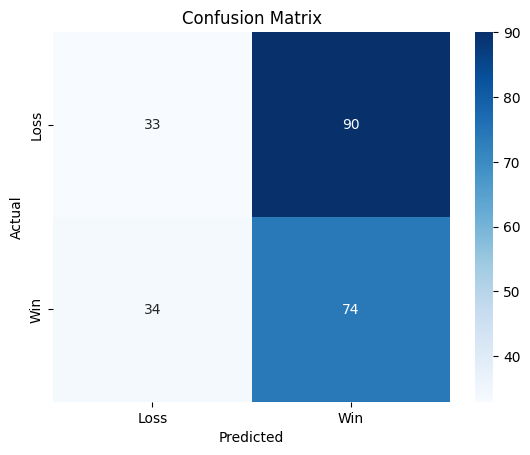

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(Y_test, pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Loss', 'Win'])
plt.plot(1, 1)
plt.yticks([0.5, 1.5], ['Loss', 'Win'])

# Display the plot
plt.show()

In [45]:
from sklearn.metrics import classification_report

# Generate a classification report
classification_rep = classification_report(Y_test, pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.49      0.27      0.35       123
           1       0.45      0.69      0.54       108

    accuracy                           0.46       231
   macro avg       0.47      0.48      0.45       231
weighted avg       0.47      0.46      0.44       231

